Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
#Import the necessary libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='training',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

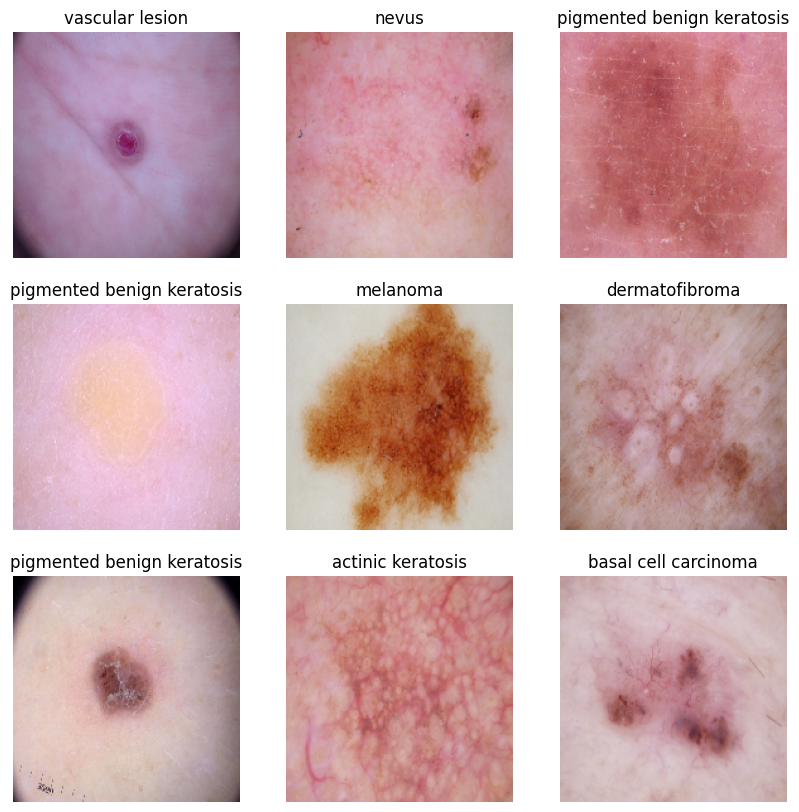

In [9]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here

target_labels = 9

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [12]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,989,801 (15.22 MB)

 Trainable params: 3,989,801 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [14]:
%%time
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 382s 3s/step - accuracy: 0.2057 - loss: 2.2037 - val_accuracy: 0.2237 - val_loss: 1.9817
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.2906 - loss: 1.9011 - val_accuracy: 0.3736 - val_loss: 1.7469
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.4211 - loss: 1.6191 - val_accuracy: 0.4653 - val_loss: 1.5675
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.4708 - loss: 1.5314 - val_accuracy: 0.5302 - val_loss: 1.4321
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.5265 - loss: 1.3540 - val_accuracy: 0.5369 - val_loss: 1.4060
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5407 - loss: 1.3070 - val_accuracy: 0.5391 - val_loss: 1.3480
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - accuracy: 0.6064 - loss: 1.1351 - val_accuracy: 0.5526 - val_loss: 1.3582
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6176 - loss: 1.1303 - val_accuracy: 0.5302 - val_loss

### Visualizing training results

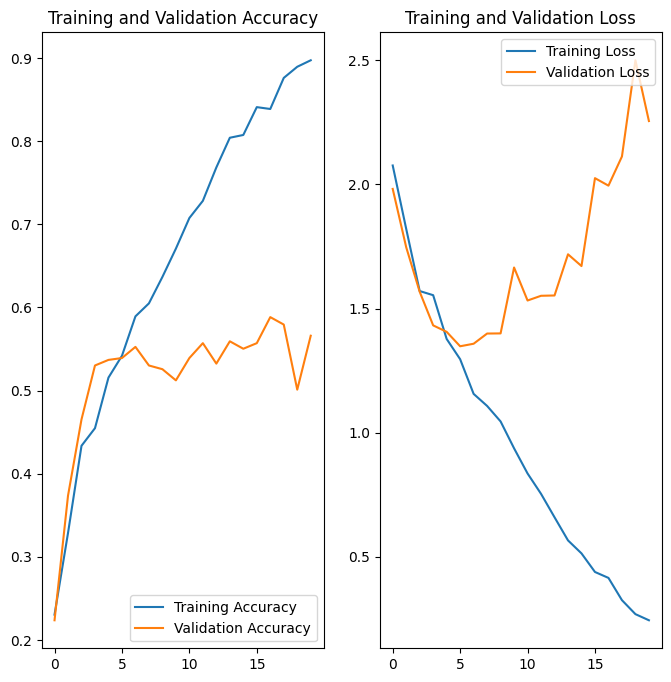

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

1. The model's training accuracy shows a steady increase, reaching around 90%, while the validation accuracy remains consistently low, at approximately 55%.

2. The significant gap between training and validation accuracy suggests that the model is learning patterns specific to the training data but struggling to generalize to unseen data.

3. The high training accuracy indicates that the model may have overfitted the training data by capturing noise and irrelevant details rather than meaningful patterns.

4. The low validation accuracy reflects the model’s inability to generalize effectively, highlighting the need for better strategies to improve performance on unseen data.

5. To combat overfitting, data augmentation techniques will be implemented. This involves generating new training samples by applying transformations such as horizontal/vertical flips, minor rotations, and other modifications to increase data variability and improve the model's generalization.

In [16]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

augmentation_data = keras.Sequential([
                                      layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),
                                      #layers.RandomContrast(0.1),

])

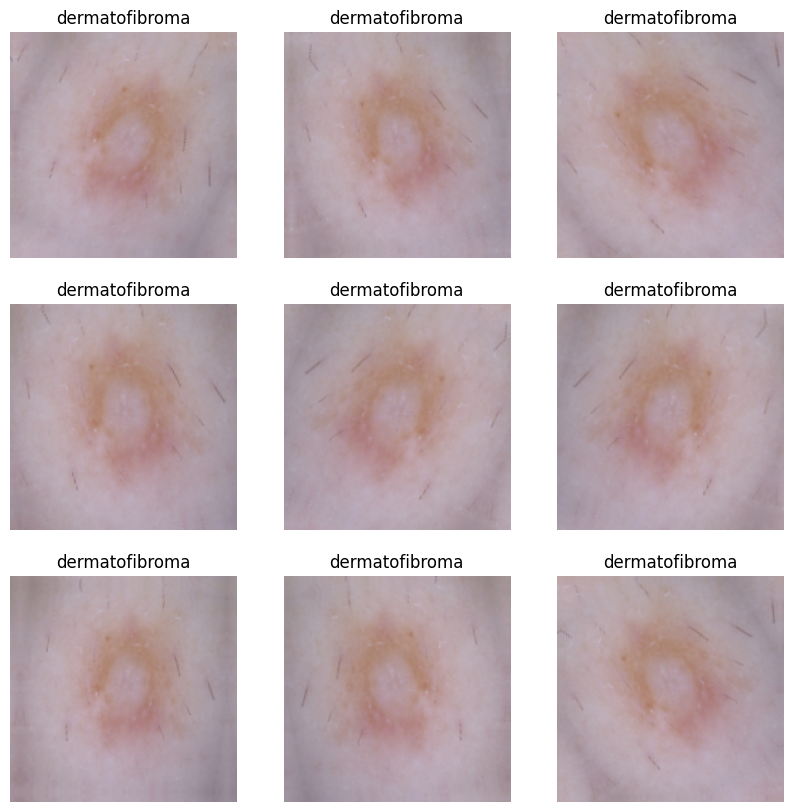

In [17]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[labels[0]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])

### Compiling the model

In [19]:
## Your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [20]:
## Your code goes here, note: train your model for 20 epochs
%%time
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2641 - loss: 2.0407 - val_accuracy: 0.3378 - val_loss: 1.7590
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3941 - loss: 1.6760 - val_accuracy: 0.4564 - val_loss: 1.6085
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4625 - loss: 1.5042 - val_accuracy: 0.5056 - val_loss: 1.5106
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.4977 - loss: 1.4267 - val_accuracy: 0.5011 - val_loss: 1.4573
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.5208 - loss: 1.3668 - val_accuracy: 0.5280 - val_loss: 1.3630
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5203 - loss: 1.3454 - val_accuracy: 0.5078 - val_loss: 1.4376
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.5157 - loss: 1.3671 - val_accuracy: 0.5145 - val_loss: 1.4065
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - accuracy: 0.5393 - loss: 1.3088 - val_accuracy: 0.5145 - val_loss:

### Visualizing the results

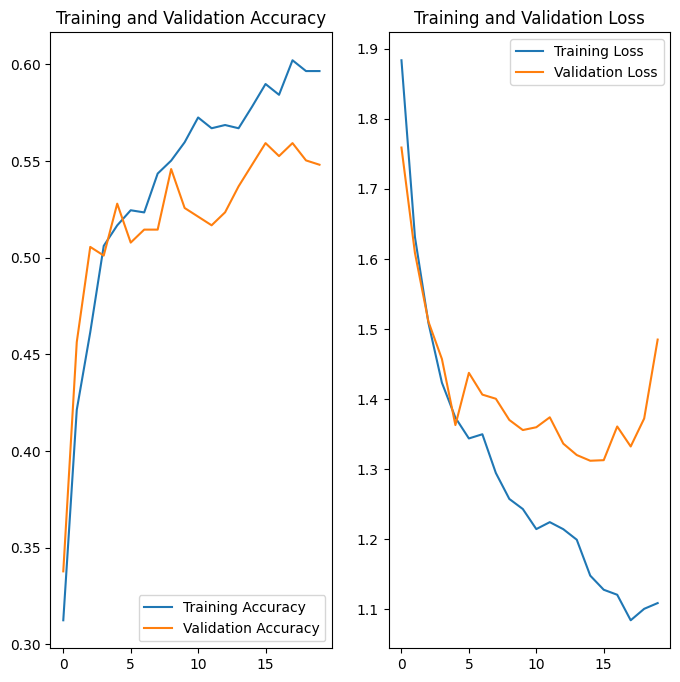

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

1. The use of augmented data has helped to effectively reduce the issue of overfitting, where the model was previously performing well on training data but poorly on validation data.

2. After applying data augmentation, both training and validation accuracy now fall within a similar range, indicating the model is no longer overfitting.

3. However, the overall accuracy for both training and validation data remains low, suggesting that the model is not learning enough meaningful patterns from the data.

4. The similar but low performance across both sets of data points to the occurrence of underfitting, where the model is too simple or not adequately tuned to capture the underlying patterns.

5. To address underfitting, further tuning of the model architecture, hyperparameters, or additional training data might be needed to improve the model’s ability to generalize and perform better.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [22]:
## Your code goes here.
from glob import glob

## Find the file paths for all image files associated with each class label
images_path_list = [ i for i in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]

## Extract the class labels from the data.
lesions_list = [ os.path.basename(os.path.dirname(j)) for j in glob(os.path.join(data_dir_train, '*', '*.jpg')) ]
print(len(lesions_list))

2239


In [23]:
# Extract image paths and corresponding class labels into a dictionary.
image_dict = dict(zip(images_path_list, lesions_list))
print(list(image_dict.items())[:5])

[('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000143.jpg', 'melanoma'), ('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000142.jpg', 'melanoma'), ('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000141.jpg', 'melanoma'), ('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000144.jpg', 'melanoma'), ('/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/ISIC_0000139.jpg', 'melanoma')]


In [24]:
# Display the image paths and corresponding class labels in a DataFrame
lesions_df = pd.DataFrame(list(image_dict.items()), columns=['Image Path', 'Label'])
lesions_df.head()

,Image Path,Label
0,/content/gdrive/My Drive/Melanoma Detection As...,melanoma
1,/content/gdrive/My Drive/Melanoma Detection As...,melanoma
2,/content/gdrive/My Drive/Melanoma Detection As...,melanoma
3,/content/gdrive/My Drive/Melanoma Detection As...,melanoma
4,/content/gdrive/My Drive/Melanoma Detection As...,melanoma


In [25]:
## Examine the class distribution in the data.
lesions_df[['Label']].value_counts()

,count
Label,
pigmented benign keratosis,462
melanoma,438
basal cell carcinoma,376
nevus,357
squamous cell carcinoma,181
vascular lesion,139
actinic keratosis,114
dermatofibroma,95
seborrheic keratosis,77


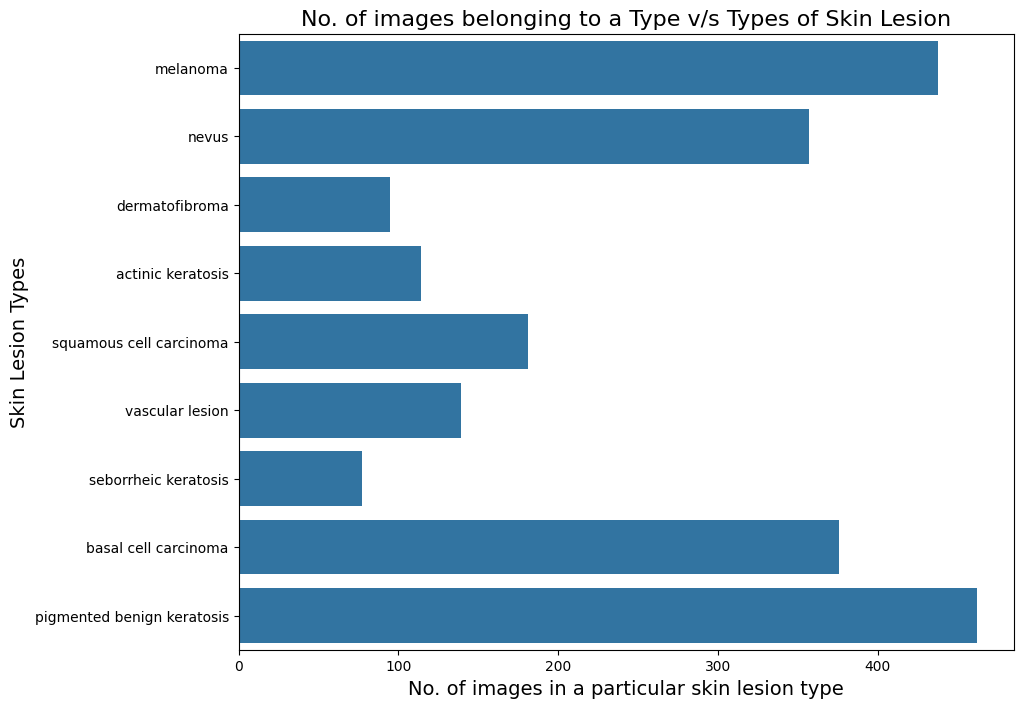

In [26]:
# Create a countplot to visualize the distribution of classes.

import seaborn as sns

plt.figure(figsize=(10, 8))
sns.countplot(y="Label", data=lesions_df)
plt.title('No. of images belonging to a Type v/s Types of Skin Lesion', fontsize=16)
plt.xlabel('No. of images in a particular skin lesion type', fontsize=14)
plt.ylabel('Skin Lesion Types', fontsize=14)
plt.show()

In [27]:
round(lesions_df[['Label']].value_counts(normalize=True)*100, 2)


,proportion
Label,
pigmented benign keratosis,20.63
melanoma,19.56
basal cell carcinoma,16.79
nevus,15.94
squamous cell carcinoma,8.08
vascular lesion,6.21
actinic keratosis,5.09
dermatofibroma,4.24
seborrheic keratosis,3.44


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

1. There is a noticeable class imbalance in the training data.  
   
2. The class "seborrheic keratosis" is underrepresented, making up only about 3.44% of the total samples.  
   
3. "Pigmented benign keratosis" holds a larger share, accounting for approximately 20.63% of the dataset.  
   
4. Similarly, "melanoma" represents a significant portion, contributing about 19.56% to the overall data.  
   
5. These two classes, "pigmented benign keratosis" and "melanoma," far exceed the representation of other classes.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset = None
path_to_training_dataset = str(data_dir_train) + '/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x79A1824439A0>: 100%|██████████| 500/500 [00:29<00:00, 17.17 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79A1825054E0>: 100%|██████████| 500/500 [00:29<00:00, 16.71 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79A18265D900>: 100%|██████████| 500/500 [00:25<00:00, 19.97 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x79A1823FF490>: 100%|██████████| 500/500 [01:48<00:00,  4.59 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x79A1822F3C40>: 100%|██████████| 500/500 [01:26<00:00,  5.81 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79A18230B7C0>: 100%|██████████| 500/500 [00:22<00:00, 22.51 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x79A18265E080>: 100%|██████████| 500/500 [00:47<00:00, 10.52 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79A1823F1B10>: 100%|██████████| 500/500 [00:25<00:00, 19.94 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x79A18265DFC0>: 100%|██████████| 500/500 [00:22<00:00, 22.16 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = None
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new[:7]

['/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010866.jpg_473c3c9c-5209-4ee9-b2ac-4197343e1fe4.jpg',
 '/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010329.jpg_31e77494-f528-4a38-99e3-7a3c4250c595.jpg',
 '/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011169.jpg_472eda62-e312-4c7c-be6f-ac0a3ea4ac12.jpg',
 '/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010469.jpg_f4936a96-2a4c-470e-a9f9-6674e8f6d21b.jpg',
 '/content/gdrive/My Drive/Melanoma Detection Assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train

In [32]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new[:7]

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma']

In [33]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [34]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)
#new_df = lesions_df.append(df2)
new_df = pd.concat([lesions_df,df2])

new_df.shape

(6739, 3)

In [35]:
new_df.head()


,Image Path,Label,Path
0,/content/gdrive/My Drive/Melanoma Detection As...,melanoma,NaN
1,/content/gdrive/My Drive/Melanoma Detection As...,melanoma,NaN
2,/content/gdrive/My Drive/Melanoma Detection As...,melanoma,NaN
3,/content/gdrive/My Drive/Melanoma Detection As...,melanoma,NaN
4,/content/gdrive/My Drive/Melanoma Detection As...,melanoma,NaN


In [36]:
new_df['Label'].value_counts()

,count
Label,
pigmented benign keratosis,962
melanoma,938
basal cell carcinoma,876
nevus,857
squamous cell carcinoma,681
vascular lesion,639
actinic keratosis,614
dermatofibroma,595
seborrheic keratosis,577


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [37]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [38]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [39]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [40]:
## your code goes here

model = Sequential([
  augmentation_data,
  layers.Rescaling(1./255),
  layers.Conv2D(16, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, (3, 3), padding='same', activation=tf.nn.relu),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation=tf.nn.relu),
  layers.Dense(target_labels)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [41]:
## your code goes here

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [42]:
%%time
epochs = 30
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.2863 - loss: 3.4946 - val_accuracy: 0.1039 - val_loss: 44.9582
Epoch 2/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 426s 2s/step - accuracy: 0.3732 - loss: 1.6167 - val_accuracy: 0.1604 - val_loss: 14.2605
Epoch 3/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 389s 2s/step - accuracy: 0.3958 - loss: 1.5484 - val_accuracy: 0.3400 - val_loss: 2.3533
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.4314 - loss: 1.4679 - val_accuracy: 0.3601 - val_loss: 2.3130
Epoch 5/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 372s 2s/step - accuracy: 0.4929 - loss: 1.3078 - val_accuracy: 0.5085 - val_loss: 1.3814
Epoch 6/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.5189 - loss: 1.2562 - val_accuracy: 0.4477 - val_loss: 1.5840
Epoch 7/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 427s 2s/step - accuracy: 0.5484 - loss: 1.1998 - val_accuracy: 0.4373 - val_loss: 1.7432
Epoch 8/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.5596 - loss: 1.1720 - val_ac

In [47]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 180, 180, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 90, 90, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,970,301 (45.66 MB)

 Trainable params: 3,990,025 (15.22 MB)

 Non-trainable params: 224 (896.00 B)

 Optimizer params: 7,980,052 (30.44 MB)

#### **Todo:**  Visualize the model results

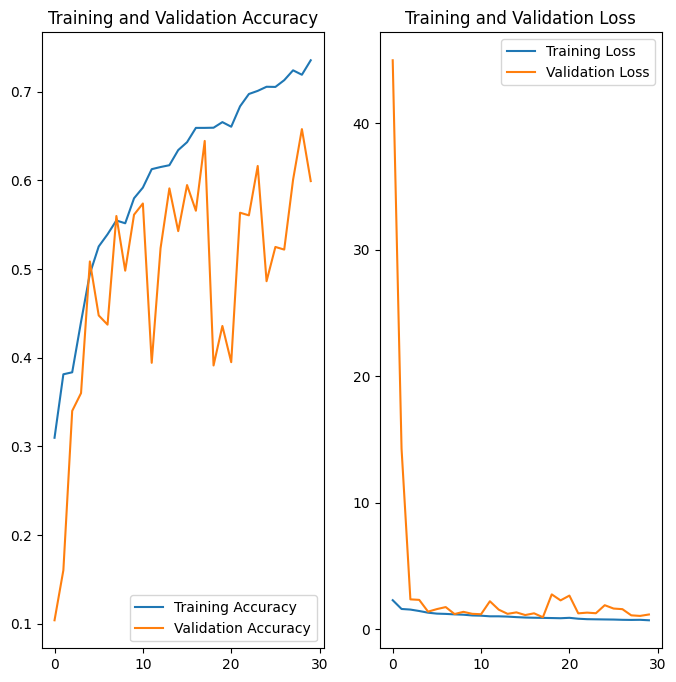

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

1. Training and Validation Accuracy: The training accuracy steadily increases over the epochs, reaching above 0.7. However, the validation accuracy fluctuates, indicating some instability, though it eventually stabilizes around 0.6 to 0.65. The fluctuation in validation accuracy may suggest the model is not generalizing perfectly and could be overfitting at certain points.

2. Training and Validation Loss: Both training and validation loss decrease rapidly in the initial epochs, but the validation loss remains higher than the training loss throughout. This consistent gap, with validation loss much higher than training loss, could be a sign of overfitting. The model performs well on the training set but struggles to maintain similar performance on the validation set.

3. Class rebalancing significantly improved the model's performance on both the training and validation datasets.

4. Incorporating batch normalization into the model resulted in a slight improvement in both training and validation accuracy.

**Model Evaluation**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Actual Class: dermatofibroma
Predicted Class: dermatofibroma


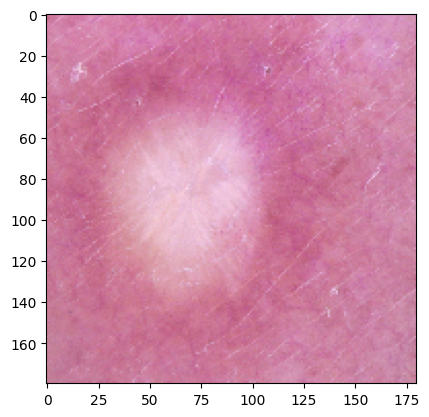

In [64]:
# Evaluating our model on one of the instances in the test set

from tensorflow.keras.preprocessing.image import load_img

image_path_test = os.path.join(data_dir_test, class_names[2], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[2] +'\n'+ "Predicted Class: " + predicted_class)